In [1]:
from fastai.vision.all import *
import ccxt.async_support as ccxt
from CoordConv import CoordConv2d

In [2]:
symbol = 'BTC/USD'
timeframe = '5m'


In [3]:
exchange = ccxt.coinbasepro()
since = exchange.parse8601('2021-01-01T00:00:00Z')
# [[timestamp, open, high, low, close, volume]]
tohlcv = []
while since < exchange.milliseconds():
  tohlcv_page = await exchange.fetch_ohlcv(symbol, timeframe, since)
  if not len(tohlcv_page):
    break
  tohlcv += tohlcv_page
  since = tohlcv[-1][0] + 1

await exchange.close()

del tohlcv[-1]

bars = len(tohlcv)
bars

166148

In [28]:
import pickle

with open('tohlcv.p', 'wb') as fp:
  pickle.dump(tohlcv, fp)

In [3]:
import pickle

tohlcv = None
with open('tohlcv.p', 'rb') as fp:
  tohlcv = pickle.load(fp)

bars = len(tohlcv)
bars

152064

In [4]:
ohlcv = np.array(tohlcv)[:, 1:]

# (bars, 5)
ohlcv.shape

(152064, 5)

In [5]:
ohlc = ohlcv[:, :-1]

# (bars, 4)
ohlc.shape

(152064, 4)

In [6]:
folder = "data"
trainingFolder = "training"
validationFolder = "validation"
testFolder = "test"

path = Path(folder)
trainingPath = path/trainingFolder
validationPath = path/validationFolder
testPath = path/testFolder

def makeDirs():
  path.mkdir(exist_ok=True)
  trainingPath.mkdir(exist_ok=True)
  validationPath.mkdir(exist_ok=True)
  testPath.mkdir(exist_ok=True)

In [7]:
makeDirs()

width = height = 32
size = (width, height)
maxY = height - 1
indexes = np.broadcast_to(np.arange(height)[::-1, np.newaxis], size)
identity = np.eye(width, dtype=bool)[::-1]
data = ohlc[1:width + 1]
highIndex = lowIndex = -1
high = low = None

In [62]:
for i in range(width + 1, bars - 1):
  if highIndex == -1:
    highIndex = data[:, 1].argmax()
    high = data[highIndex, 1]
  if lowIndex == -1:
    lowIndex = data[:, 2].argmin()
    low = data[lowIndex, 2]

  range_ = high - low
  n = ((data - low) / range_ * maxY).astype(np.uint8)

  r = ((indexes <= n[:, 1]) & (indexes >= n[:, 2])) # TODO only update these if the high/low index was recalculated or replaced, otherwise only calculate for the new bar, also all numbers in the colunn after the first that is true is guarantted to be rue so dont check them
  g = identity[:, n[:, 0]]
  b = identity[:, n[:, 3]]
  np.save((testPath if i > 0.95 * bars else (validationPath if i > 0.90 * bars else trainingPath))/str(i), np.packbits(np.stack((r, g, b)), 1))

  newBar = ohlc[i]
  data = np.vstack((data[1:], newBar))

  newBarHigh = newBar[1]
  newBarLow = newBar[2]
  if newBarHigh > high:
    highIndex = maxY
    high = newBarHigh
  else:
    highIndex -= 1
  if newBarLow < low:
    lowIndex = maxY
    low = newBarLow
  else:
    lowIndex -= 1

In [8]:
v = ohlcv[:, -1]
# v = v / v.mean()
# v = ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)
# v = np.broadcast_to(v, (height, bars))

# (height,)
v.shape

(152064,)

In [9]:
change = np.diff(ohlc[:, -1]) / ohlc[:-1, -1] * 100
c = ((change - change.min()) / (change.max() - change.min()) * 255).astype(np.uint8)
c = np.broadcast_to(c, (height, bars - 1))

# (bars - 1,), (height, bars - 1)
change.shape, c.shape

((152063,), (32, 152063))

In [10]:
def _fig_bounds(x):
  # not sure why this is here but fast.ai uses it in their show_image method
  r = x//32
  return min(5, max(1, r))

def scale_tensor_to_image(im_tensor):
  # scales the tensor values to fit between 0 and 1
  im_min = torch.min(im_tensor)
  im_max = torch.max(im_tensor)
  return (255*(im_tensor - im_min)//(im_max - im_min)).type(torch.uint8)

def show_tensor_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
  # basically fast.ai's show_image with an additional function to scale the values
  # between 0 and 1 for arbitrary tensors
  "Show a PIL or PyTorch image on `ax`."
  # Handle pytorch axis order
  if hasattrs(im, ('data','cpu','permute')):
      im = im.data.cpu()
      if im.shape[0]<5: im=im.permute(1,2,0)
  elif not isinstance(im,np.ndarray): im=array(im)
  # Handle 1-channel images
  if im.shape[-1]==1: im=im[...,0]
  
  if torch.max(im) != torch.min(im):
      im = scale_tensor_to_image(im)
  else:
      im = im.type(torch.uint8)

  ax = ifnone(ax,ctx)
  if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
  if ax is None: _,ax = plt.subplots(figsize=figsize)
  ax.imshow(im, **kwargs)
  if title is not None: ax.set_title(title)
  ax.axis('off')
  return ax

class TorchTensorImage(TensorImage):
  _show_args = {'cmap': 'viridis'}
  @classmethod
  def create(cls, fn):
    # fn is filename, use this method to handle how your data should be loaded
    # will need to be changed to load your data in a form your model can handle
    i = int(fn.stem)
    volume = v[i-width:i]
    volumemin = volume.min()
    volume = ((volume - volumemin) / (volume.max() - volumemin) * 255).astype(np.uint8)
    volume = np.broadcast_to(volume, (height, width))
    volume = volume[np.newaxis]
    change_ = c[np.newaxis, :, i - width - 1:i - 1]
    input_tensor = np.unpackbits(np.load(fn), 1) * np.uint8(255)
    input_tensor = np.vstack((input_tensor, volume, change_))
    return cls(input_tensor)

  def show(self, ctx=None, **kwargs):
    # defines how your tensor should be displayed
    "Show image using `merge(self._show_args, kwargs)`"
    return show_tensor_image(self[:4], ctx=ctx, **merge(self._show_args, kwargs))

def TensorImageBlock():
  # creates the torch Tensor TransformBlock using the above Transforms
  return TransformBlock(type_tfms=TorchTensorImage.create, batch_tfms=IntToFloatTensor())

In [11]:
def get_y(o):
  return np.sign(change[int(o.stem) - 1])
  # return change[int(o.stem) - 1]

f:\GitHub\money\envs\lib\site-packages\torch\_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


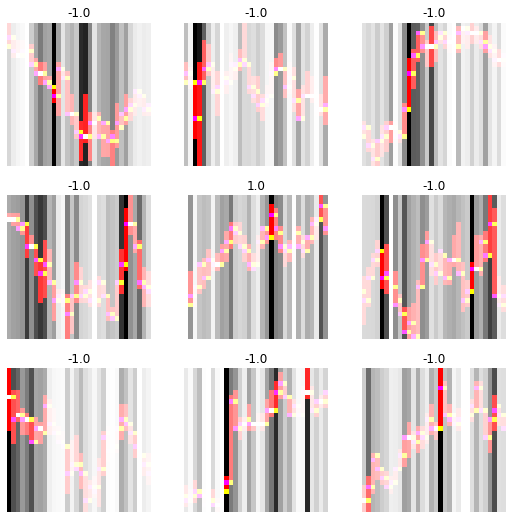

In [12]:
dblock = DataBlock(blocks=(TensorImageBlock, RegressionBlock),
                    get_items=lambda get_items: get_files(path, extensions='.npy', folders=(trainingFolder, validationFolder)),
                    # splitter=FuncSplitter(lambda o: Path(o).parent.name == validationFolder),
                    splitter=RandomSplitter(valid_pct=0.05, seed=0),
                    get_y=get_y,
                    batch_tfms=Normalize()
                  )
dls = dblock.dataloaders(path, bs=512, num_workers=0, device=torch.device('cuda'))
dls.show_batch()

In [13]:
class res(Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=3,
                 pool=AvgPool, pool_first=True, **kwargs):
        norm2 = (NormType.BatchZero if norm_type == NormType.Batch else
                 NormType.InstanceZero if norm_type == NormType.Instance else norm_type)
        if nh2 is None:
            nh2 = nf
        if nh1 is None:
            nh1 = nh2
        nf, ni = nf*expansion, ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath = [ConvLayer(ni,  nh2, ks, stride=stride, bn_1st=False, bias=True, groups=ni if dw else groups, **k0),
                    ConvLayer(nh2,  nf, ks, bn_1st=False, bias=True, groups=g2, **k1)
                    ] if expansion == 1 else [
            ConvLayer(ni,  nh1, 1, **k0),
            ConvLayer(nh1, nh2, ks, stride=stride,
                      groups=nh1 if dw else groups, **k0),
            ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction:
            convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa:
            convpath.append(SimpleSelfAttention(nf, ks=1, sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni != nf:
            idpath.append(
                ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride != 1:
            idpath.insert((1, 0)[pool_first], pool(
                stride, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(
            inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [16]:
class SkipConvolutions(Module):
  def __init__(self):
    # self.conv1 = conv(5, 4, stride=1, coord=True) # 16
    # self.conv2 = conv(4, 4, stride=1)
    # self.conv3 = conv(4, 8) # 8
    # self.conv4 = conv(8, 8, stride=1)
    # self.conv5 = conv(8, 16) # 4
    # self.conv6 = conv(16, 16, stride=1)
    # self.conv7 = conv(16, 32) # 2
    # self.conv8 = conv(32, 32, stride=1)
    self.conv1 = conv(3, 16, ks=5, stride=1, coord=True) # 32
    self.conv2 = conv(16, 16, ks=5, stride=1)
    # self.conv3 = conv(16, 16) # 16
    # self.conv4 = conv(16, 16, stride=1)
    # self.conv5 = conv(16, 16) # 8
    # self.conv6 = conv(16, 16, stride=1)
    # self.conv7 = conv(32, 64) # 4
    # self.conv8 = conv(64, 64, stride=1)

  def forward(self, x):
    first = self.conv2(self.conv1(x))
    second = self.conv2(self.conv2(first))
    # third = self.conv6(self.conv6(self.conv5(second)))
    # fourth = self.conv8(self.conv8(self.conv7(third)))
    return torch.hstack((first.flatten(start_dim=1), second.flatten(start_dim=1)))

In [14]:
def m():
  return sequential(
    # SkipConvolutions(),
    # PrintLayer(),
    CoordConv2d(5, 4, conv=ConvLayer, extra=PrintLayer, kernel_size=(7,1), padding=(7//2,0)), # 32
    res(1, 4, 4, ks=(5,1), padding=(5//2,0)),
    # SkipBlock(16, ks=5),
    
    ConvLayer(4, 8, ks=5, stride=2, bias=True, bn_1st=False), # 16
    res(1, 8, 8, ks=5),
    ConvLayer(8, 2, ks=5, stride=2, bias=True, bn_1st=False), # 8
    res(1, 2, 2, ks=3),
    ConvLayer(2, 1, ks=3, stride=2, bias=True, bn_1st=False), # 4
    res(1, 1, 1, ks=3),
    # conv(64, 128), # 2
    # conv(128, 256), # 1
    Flatten(),
    nn.Dropout(0.5),

    # nn.Dropout2d(0.95),
    # Flatten(),
    nn.Linear(1*4*4, 8), # remove bias=False when batchnorm is removed in next line, because bias and batchnorm cancel out
    # nn.BatchNorm1d(16) # remove when using dropout, because variance shift
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Tanh()
)

In [15]:
def mean_profit(inp, targ):
  inp, targ = flatten_check(inp, targ)
  return (targ[inp>0]).mean()

def positive_mean_profit(inp, targ):
  inp, targ = flatten_check(inp, targ)
  return (inp.sign() * targ).mean()

# def positive_guess_percent(inp, targ):
#   return (inp > 0).count_nonzero() / inp.numel() * 100

def profitable_guess_percent(inp, targ):
  inp, targ = flatten_check(inp, targ)
  return ((inp*targ)>0).count_nonzero() / inp.numel() * 100

def positive_profitable_guess_percent(inp, targ):
  inp, targ = flatten_check(inp, targ)
  return ((inp > 0) & ((inp * targ) > 0)).count_nonzero() / (inp > 0).count_nonzero() * 100

# def average_guess(inp, targ):
#   return inp.mean()

# def average_target(inp, targ):
#   return targ.mean()

# def positive_target_percent(inp, targ):
#   return (targ > 0).count_nonzero() / targ.numel() * 100

In [63]:
class PrintLayer(Module):
  def forward(self, x):
    # print(x.shape)
    # print(x[0, 0])
    # show_image(x[0, :4], cmap='gray', figsize=(5,5))
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sequential (Input shape: 512 x 5 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 7 x 32 x 32   
AddCoords                                                      
PrintLayer                                                     
____________________________________________________________________________
                     512 x 4 x 32 x 32   
Conv2d                                    200        True      
ReLU                                                           
BatchNorm2d                               8          True      
Conv2d                                    84         True      
ReLU                                                           
BatchNorm2d                               8          True      
Conv2d                                    84         True      
BatchNorm2d                               8          True      
Sequential                                                     
ReLU                       

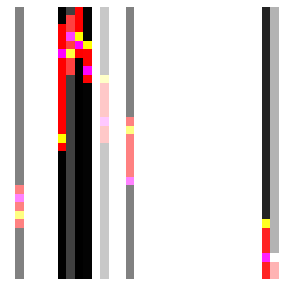

In [17]:
learn = Learner(dls, m(), loss_func=L1LossFlat(), metrics=(mean_profit, profitable_guess_percent), cbs=SaveModelCallback(), lr=3e-4, wd=1e-5)
learn.summary()

SuggestedLRs(minimum=0.33113112449646, steep=1.0964782238006592, valley=0.25118863582611084, slide=0.2089296132326126)

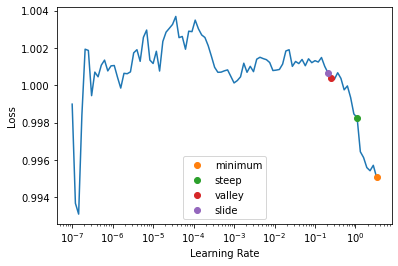

In [163]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [164]:
learn.fit(100)

epoch,train_loss,valid_loss,mean_profit,profitable_guess_percent,time
0,0.999280,1.000603,0.004432,50.200802,02:38
1,0.997924,0.999655,0.005539,50.256199,02:37
2,0.995208,0.998939,0.004155,50.186954,02:39
3,0.991249,0.995199,0.008586,50.408531,02:21
4,0.985519,0.986318,0.036837,51.821079,02:19
5,0.984783,0.974513,0.045700,52.264229,02:36
6,0.969861,0.971086,0.038222,51.890320,02:26
7,0.971937,0.958839,0.054563,52.707382,02:19
8,0.970394,0.965345,0.045977,52.278076,02:20
9,0.966246,0.950040,0.062318,53.095139,02:19


Better model found at epoch 0 with valid_loss value: 1.0006030797958374.
Better model found at epoch 1 with valid_loss value: 0.9996554255485535.
Better model found at epoch 2 with valid_loss value: 0.998939037322998.
Better model found at epoch 3 with valid_loss value: 0.995198667049408.
Better model found at epoch 4 with valid_loss value: 0.9863176345825195.
Better model found at epoch 5 with valid_loss value: 0.9745128154754639.
Better model found at epoch 6 with valid_loss value: 0.9710861444473267.
Better model found at epoch 7 with valid_loss value: 0.9588386416435242.
Better model found at epoch 9 with valid_loss value: 0.950039803981781.
Better model found at epoch 10 with valid_loss value: 0.9453586935997009.
Better model found at epoch 11 with valid_loss value: 0.9369620084762573.
Better model found at epoch 15 with valid_loss value: 0.9369459748268127.
Better model found at epoch 17 with valid_loss value: 0.9327036142349243.
Better model found at epoch 18 with valid_loss val

KeyboardInterrupt: 

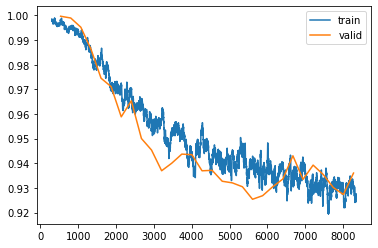

In [165]:
learn.recorder.plot_loss(skip_start=300, with_valid=True)

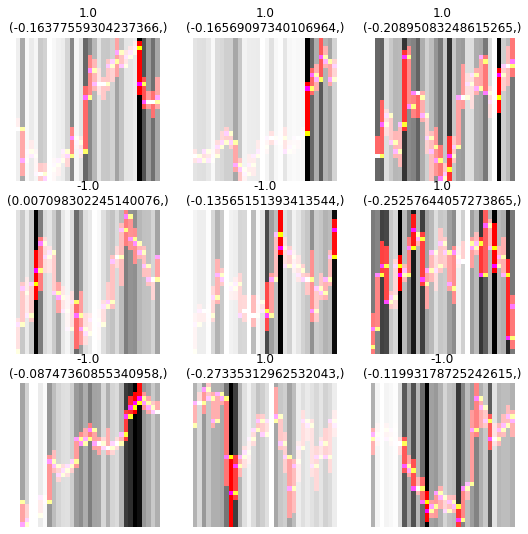

In [18]:
learn.show_results()

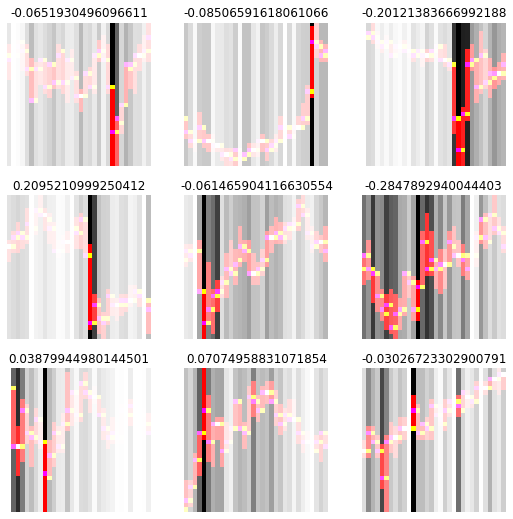

In [18]:
dblock1 = DataBlock(blocks=(TensorImageBlock, RegressionBlock),
                   get_items=lambda get_items: get_files(
                       path, extensions='.npy', folders=(validationFolder, testFolder)),
                   splitter=FuncSplitter(lambda o: Path(o).parent.name == testFolder),
                #    splitter=RandomSplitter(valid_pct=1, seed=0),
                   get_y=lambda o: change[int(o.stem) - 1],
                   batch_tfms=Normalize()
                   )
dls1 = dblock1.dataloaders(path, bs=512, num_workers=0,
                         device=torch.device('cuda'))
dls1.show_batch()

In [19]:
np.mean(np.abs([change[int(i.stem)-1] for i in get_files(path, extensions='.npy', folders=(testFolder))]))

0.12509272448575437

In [21]:
learn.validate(dl=dls1[1])

Better model found at epoch 0 with valid_loss value: 0.007399838883429766.


(#3) [0.2469302862882614,0.007399838883429766,50.15785217285156]

In [64]:
learn1 = Learner(dls1, m(), loss_func=L1LossFlat(), metrics=(
    mean_profit, positive_mean_profit, profitable_guess_percent, positive_profitable_guess_percent), cbs=SaveModelCallback(), lr=3e-4, wd=1e-5)
learn1.load('model copy')

f:\GitHub\money\envs\lib\site-packages\fastai\learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [23]:
learn1.validate(dl=dls1[1])

Better model found at epoch 0 with valid_loss value: 0.0031554780434817076.


(#5) [0.8841926455497742,0.0031554780434817076,0.003780041355639696,53.02552032470703,53.534217834472656]

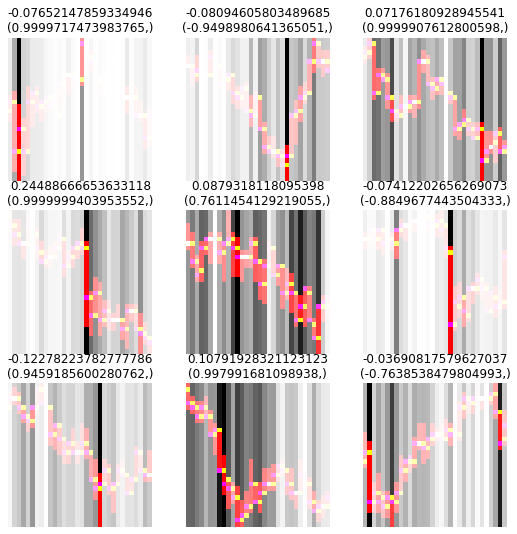

In [24]:
learn1.show_results()

In [71]:
%load_ext dotenv
%dotenv -ov

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [22]:
import alpaca_trade_api as tradeapi
from time import sleep

In [72]:
total_buying_power = 5000

class Trader:
  def __init__(self):
    self.alpaca = tradeapi.REST()
    self.exchange = ccxt.coinbasepro()
    self.last_price = 0

  async def run(self):
    for _ in range(100):
      i = 33
      etohlcv = await self.exchange.fetch_ohlcv(symbol, timeframe, limit=width+1)
      await self.exchange.close()

      eohlcv = np.array(etohlcv)[:, 1:]
      eohlc = eohlcv[:, :-1]
      self.last_price = eohlc[-1, -1]

      data = eohlc[1:width + 1]
      high = data[:, 1].max()
      low = data[:, 2].min()

      range_ = high - low
      n = ((data - low) / range_ * maxY).astype(np.uint8)

      r = ((indexes <= n[:, 1]) & (indexes >= n[:, 2])) # TODO only update these if the high/low index was recalculated or replaced, otherwise only calculate for the new bar, also all numbers in the colunn after the first that is true is guarantted to be rue so dont check them
      g = identity[:, n[:, 0]]
      b = identity[:, n[:, 3]]

      v = eohlcv[:, -1]
      change = np.diff(eohlc[:, -1]) / eohlc[:-1, -1] * 100
      c = ((change - change.min()) / (change.max() - change.min()) * 255).astype(np.uint8)
      c = np.broadcast_to(c, (height, width))
      volume = v[i-width:i]
      volumemin = volume.min()
      volume = ((volume - volumemin) / (volume.max() - volumemin)
                * 255).astype(np.uint8)
      volume = np.broadcast_to(volume, (height, width))
      volume = volume[np.newaxis]
      change_ = c[np.newaxis, :, i - width - 1:i - 1]
      input_tensor = np.stack((r, g, b)) * np.uint8(255)
      input_tensor = np.vstack((input_tensor, volume, change_))
      input_tensor = TorchTensorImage(input_tensor)

      prediction, _, _ = learn1.predict(input_tensor)
      print(prediction)

      # Calculate the number of shares we want to be holding
      target_value = prediction[0] * total_buying_power + total_buying_power
      # if target_value < 0:
      #     target_value = 0
      # target_qty = target_value / self.last_price
      target_qty = target_value 
      self.send_order(target_qty)
      for i in range(99):
        if os.path.exists(os.path.join(os.getcwd(),'zstop-true')):
          break
        sleep(3)
      else:
        continue
      break

  def send_order(self, target_qty):
    self.alpaca.cancel_all_orders()

    try:
      positionData = self.alpaca.get_position(symbol.replace('/',''))
      qty = float(positionData.qty)
      position = float(positionData.market_value)
    except:
      position = 0
      qty = 0
    print(position)
    delta = target_qty - position
    if delta == 0:
      return
    print(f'Ordering towards ${target_qty}...')
    try:
      if delta > 0:
        buy_qty = delta
        print(f'Buying ${buy_qty}')
        self.alpaca.submit_order(symbol, notional=buy_qty, side='buy', type='limit', limit_price=round(self.last_price))
      elif delta < 0:
        sell_qty = abs(delta) / position * qty
        print(f'Selling {sell_qty} shares')
        self.alpaca.submit_order(symbol, qty=sell_qty, side='sell', type='limit', limit_price=round(self.last_price))
    except Exception as e:
      print(e)

In [73]:
ls = Trader()
await ls.run()

(1.0,)
0
Ordering towards $10000.0...
Buying $10000.0


(-0.1327393352985382,)
0
Ordering towards $4336.303323507309...
Buying $4336.303323507309


(1.0,)
4316.3216712
Ordering towards $10000.0...
Buying $5683.6783288


(1.0,)
9978.7622342
Ordering towards $10000.0...
Buying $21.23776580000049


(-1.0,)
10008.9715336
Ordering towards $0.0...
Selling 0.4344926 shares


(-1.0,)
9976.8190812
Ordering towards $0.0...
Selling 0.4344926 shares


(1.0,)
9996.3712482
Ordering towards $10000.0...
Buying $3.6287518000008276


(-0.9999995827674866,)
10006.4877075
Ordering towards $0.002086162567138672...
Selling 0.43459220939576254 shares


(-1.0,)
2.1245614
Ordering towards $0.0...
Selling 9.23e-05 shares
qty must be >= 0.0001


(1.0,)
2.1211463
Ordering towards $10000.0...
Buying $9997.8788537


(1.0,)
9982.1874892
Ordering towards $10000.0...
Buying $17.812510800000382


(1.0,)
9988.6945725
Ordering towards $10000.0...
Buying $11.305427499999496


(1.0,)
9981.7779594
Ordering towards $10000.0...
Buying $18.222040599999673


(-1.0,)
10013.4777068
Ordering towards $0.0...
Selling 0.4354822 shares


(-1.0,)
1.8928194
Ordering towards $0.0...
Selling 8.22e-05 shares
qty must be >= 0.0001


(-0.9999998807907104,)
1.8906
Ordering towards $0.0005960464477539062...
Selling 8.217408493705418e-05 shares
qty must be >= 0.0001


(-0.9999997019767761,)
1.8931482
Ordering towards $0.0014901161193847656...
Selling 8.213529954759304e-05 shares
qty must be >= 0.0001


(1.0,)
1.8995598
Ordering towards $10000.0...
Buying $9998.1004402


(1.0,)
9946.8614952
Ordering towards $10000.0...
Buying $53.13850479999928


(1.0,)
9963.6854868
Ordering towards $10000.0...
Buying $36.314513200000874


(-0.9999998211860657,)
9990.4352121
Ordering towards $0.0008940696716308594...
Selling 0.43287986126046746 shares


(-0.9999997019767761,)
1.8481669
Ordering towards $0.0014901161193847656...
Selling 7.983557926075896e-05 shares
qty must be >= 0.0001


(0.9853047728538513,)
1.8449709
Ordering towards $9926.523864269257...
Buying $9924.678893369257


(1.0,)
9899.4229524
Ordering towards $10000.0...
Buying $100.57704759999979


(1.0,)
9988.9467099
Ordering towards $10000.0...
Buying $11.053290100000595


(-0.9999999403953552,)
9986.0224651
Ordering towards $0.0002980232238769531...
Selling 0.43317668707225854 shares


(-1.0,)
1.7683185
Ordering towards $0.0...
Selling 7.67e-05 shares
qty must be >= 0.0001


(-0.9998577833175659,)
1.7742244
Ordering towards $0.7110834121704102...
Selling 4.595975219737117e-05 shares
qty must be >= 0.0001


(-0.9999914169311523,)
1.7729972
Ordering towards $0.04291534423828125...
Selling 7.484347879225292e-05 shares
qty must be >= 0.0001


(1.0,)
1.7726137
Ordering towards $10000.0...
Buying $9998.2273863


(1.0,)
9972.4689416
Ordering towards $10000.0...
Buying $27.531058399999893


(-0.9935309290885925,)
9989.1804177
Ordering towards $32.34535455703735...
Selling 0.430975850025666 shares


(1.0,)
34.0962418
Ordering towards $10000.0...
Buying $9965.9037582


(0.8093076348304749,)
9950.6955141
Ordering towards $9046.538174152374...
Selling 0.039197006110357896 shares


(-0.9999930262565613,)
9056.2291778
Ordering towards $0.034868717193603516...
Selling 0.39228078961633916 shares


(-0.9999930262565613,)
9035.0459336
Ordering towards $0.034868717193603516...
Selling 0.3922807860751479 shares


(1.0,)
9033.4768044
Ordering towards $10000.0...
Buying $966.5231956000007


(0.057919930666685104,)
9990.6807622
Ordering towards $5289.5996533334255...
Selling 0.20424386796135788 shares


(0.999998152256012,)
5301.4126224
Ordering towards $9999.99076128006...
Buying $4698.57813888006


(0.9997341632843018,)
9980.9913022
Ordering towards $9998.670816421509...
Buying $17.679514221508725


(1.0,)
10004.8879649
Ordering towards $10000.0...
Selling 0.0002118111062962748 shares


(1.0,)
9984.238848
Ordering towards $10000.0...
Buying $15.761151999999129


(1.0,)
9955.4950698
Ordering towards $10000.0...
Buying $44.50493020000067


(1.0,)
10017.695057
Ordering towards $10000.0...
Selling 0.0007698523819882886 shares


(1.0,)
9996.3839226
Ordering towards $10000.0...
Buying $3.6160773999999947


(-0.9998713135719299,)
10030.4465514
Ordering towards $0.6434321403503418...
Selling 0.43520798052849297 shares


(1.0,)
0.8247666
Ordering towards $10000.0...
Buying $9999.1752334


(1.0,)
9958.2664547
Ordering towards $10000.0...
Buying $41.733545299999605


(1.0,)
9976.2527052
Ordering towards $10000.0...
Buying $23.74729479999951


(1.0,)
9965.901715
Ordering towards $10000.0...
Buying $34.09828500000003


(1.0,)
10017.909678
Ordering towards $10000.0...
Selling 0.0007830736740850853 shares


(0.998068630695343,)
10004.961204
Ordering towards $9990.343153476715...
Selling 0.0006389566624392072 shares


(0.998068630695343,)
9950.182912
Ordering towards $9990.343153476715...
Buying $40.16024147671487


(1.0,)
9998.4445974
Ordering towards $10000.0...
Buying $1.555402600000889
notional must be >= 2.2807 to satisfy minimum qty of 0.0001


(1.0,)
9991.429991
Ordering towards $10000.0...
Buying $8.570008999999118


(1.0,)
10001.317464
Ordering towards $10000.0...
Selling 5.779111286571677e-05 shares
qty must be >= 0.0001


(1.0,)
9977.627016
Ordering towards $10000.0...
Buying $22.372983999999633


(1.0,)
10002.4304029
Ordering towards $10000.0...
Selling 0.00010681681096996156 shares


(-0.9999999403953552,)
9994.8809913
Ordering towards $0.0002980232238769531...
Selling 0.4395092868948936 shares


(1.0,)
0.211482
Ordering towards $10000.0...
Buying $9999.788518


(0.9999748468399048,)
9978.5598135
Ordering towards $9999.874234199524...
Buying $21.314420699523907


(1.0,)
9978.5598135
Ordering towards $10000.0...
Buying $21.44018649999998


(1.0,)
10014.3602156
Ordering towards $10000.0...
Selling 0.0006297787737917604 shares


(0.9999995827674866,)
10033.5731006
Ordering towards $9999.997913837433...
Selling 0.0014676394091256582 shares


(0.999966561794281,)
10025.6785202
Ordering towards $9999.832808971405...
Selling 0.001130658000288471 shares


(1.0,)
10028.7486348
Ordering towards $10000.0...
Selling 0.001257265582086951 shares


(-1.0,)
10008.7450274
Ordering towards $0.0...
Selling 0.4373878 shares


(1.0,)
2.0078982
Ordering towards $10000.0...
Buying $9997.9921018


(-0.9998464584350586,)
9970.239061
Ordering towards $0.7677078247070312...
Selling 0.435842937534987 shares


(-0.9998464584350586,)
1.7484075
Ordering towards $0.7677078247070312...
Selling 4.290963357221478e-05 shares
qty must be >= 0.0001
